/var/folders/96/90n8349x5b95fcv_bb51ds740000gn/T/ipykernel_19208/3708870237.py:113: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * t)


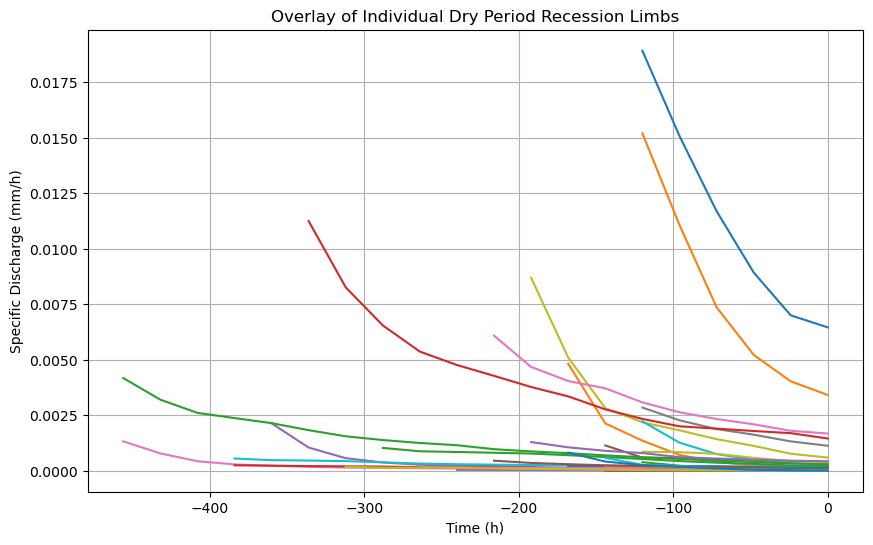

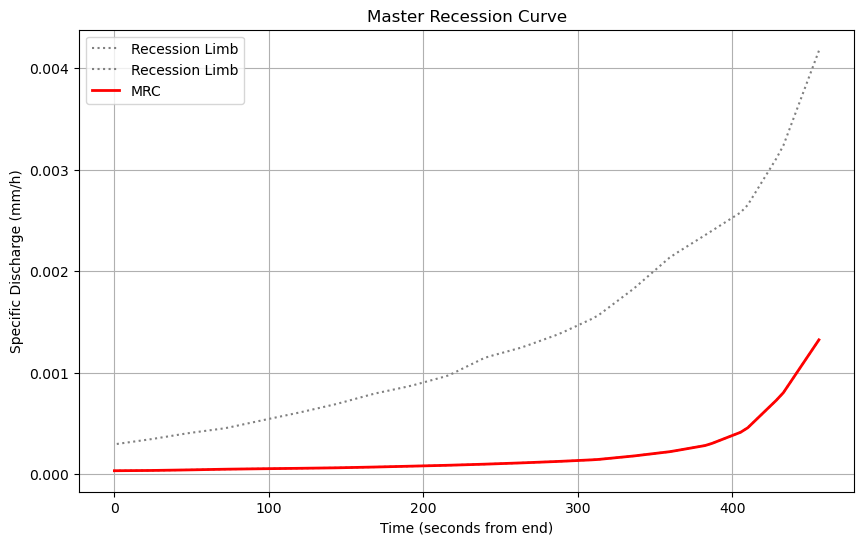

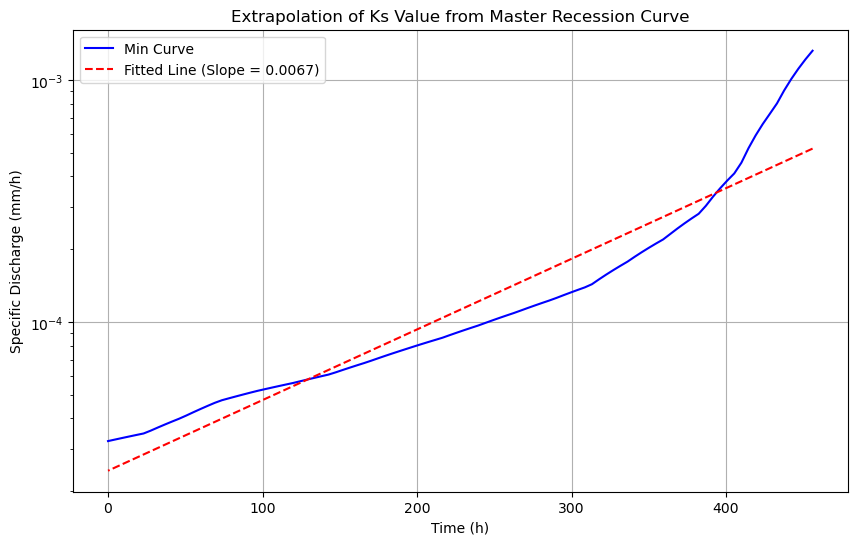

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from datetime import datetime
from scipy.interpolate import interp1d

# Load discharge data from Excel file
file_path = 'discharge.xlsx'  # Replace with your actual file path
df = pd.read_excel(file_path)
df.replace(-999, 0, inplace=True)
df['Colonna2'] = pd.to_numeric(df['Colonna2'], errors = "coerce") /201001000000 * 60 *60 *1000
df['Colonna1'] = pd.to_datetime(df['Colonna1'], format='%Y-%m-%d', errors = "coerce")


df = df.dropna(subset=['Colonna2'])
# Assuming the Excel file has 'Time' and 'Discharge' columns
time = df['Colonna1'].values
discharge = df['Colonna2'].values 

last_five_years_mask = time >= (time.max() - pd.DateOffset(years=5))
time_short = time[last_five_years_mask].astype('timedelta64[s]').astype(np.float64)/1e09 /60/60
dis_short = discharge[last_five_years_mask]
time_y = time[last_five_years_mask]

# Define a function to detect recession periods
def detect_recession_periods(time, discharge, threshold=0):
    recessions = []
    current_recession = []
    
    for i in range(1, len(discharge)):
        if (discharge[i] < discharge[i - 1]):  # Condition for recession (flow is decreasing)
            current_recession.append((time[i], discharge[i]))
        else:
            if len(current_recession) > 5:  # End of a recession period
                recessions.append(np.array(current_recession))
            current_recession = []
    
    return recessions

def lowest_curve(time, discharge, threshold=0):
    recessions = []
    current_recession = []
    
    for i in range(1, len(discharge)):
        if (discharge[i] < discharge[i - 1]): 
            current_recession.append((time[i], discharge[i]))
        else:
            if len(current_recession) > 19: 
                recessions.append(np.array(current_recession))
            current_recession = []
    max_time_from_end = 0 

    interpolated_recessions = []

    for recession in recessions:
        recession_time = recession[:, 0].astype('datetime64[s]')
        discharge_values = recession[:, 1]


        time_from_end = (recession_time - recession_time[-1]).astype('timedelta64[s]').astype(np.float64)

        max_time_from_end = max(max_time_from_end, abs(time_from_end[0]))  # Find the maximum time extent
        interp_func = interp1d(time_from_end, discharge_values, bounds_error=False, fill_value=np.nan)  # Interpolation function
        interpolated_recessions.append(interp_func)

    
    time_grid = np.linspace(-max_time_from_end, 0, 100)
    min_curve = np.full_like(time_grid, np.inf)  

    for interp_func in interpolated_recessions:
        discharge_interp = interp_func(time_grid)  # Interpolated values for this recession
        min_curve = np.minimum(min_curve, discharge_interp)  # Take the element-wise minimum

    
    plt.figure(figsize=(10, 6))

    for interp_func in interpolated_recessions:
        plt.plot(-time_grid, interp_func(time_grid), label='Recession Limb', linestyle=':', color='gray')

    
    plt.plot(-time_grid, min_curve, label='MRC', color='red', linewidth=2)

    plt.xlabel('Time (seconds from end)')
    plt.ylabel('Specific Discharge (mm/h)')
    plt.title('Master Recession Curve')
    plt.grid(True)
    plt.legend()
    plt.savefig("MRC", dpi = 300)
    plt.show()

    log_discharge = np.log(min_curve)  

    slope, intercept = np.polyfit(-time_grid, log_discharge, 1) 
    fitted_log_discharge = slope * (-time_grid) + intercept


    plt.figure(figsize=(10, 6))

    plt.plot(-time_grid, min_curve, label='Min Curve', color='blue')
    plt.plot(-time_grid, np.exp(fitted_log_discharge), label=f'Fitted Line (Slope = {slope:.4f})', color='red', linestyle='--')
    plt.yscale('log')

    plt.xlabel('Time (h)')
    plt.ylabel('Specific Discharge (mm/h)')
    plt.title('Extrapolation of Ks Value from Master Recession Curve')
    plt.grid(True)
    plt.legend()
    plt.savefig("Ks_val", dpi = 300)
    plt.show()

def exp_decay(t, a, b):
    return a * np.exp(-b * t)

def create_master_recession_curve(recessions):
    master_curve = []
    
    for recession in recessions:
        t1 = (recession[0, 0])
        t2 = (recession[:, 0])
        t = (t2-t1)
        Q = recession[:, 1].astype(float)
        try:
            params, _ = curve_fit(exp_decay, t, Q)
            a, b = params
            fitted_curve = exp_decay(t, a, b)
            master_curve.append((t, fitted_curve))
        except RuntimeError:
            pass  
            
    
    return master_curve

# Plot the Master Recession Curve
def plot_master_curve(master_curve, time_y):
        
    plt.figure(figsize=(10, 6))
    for i, recession in enumerate(recessions):
        recession_time = recession[:, 0]
        discharge = recession[:, 1] 

        time_from_end = (recession_time - recession_time[-1])

        plt.plot(time_from_end, discharge)

        plt.title("Overlay of Individual Dry Period Recession Limbs")
        plt.xlabel('Time (h)')
        plt.ylabel('Specific Discharge (mm/h)')
        plt.grid(True)
        plt.savefig("overlay", dpi = 300)




recessions = detect_recession_periods(time_short, dis_short)
master_curve = create_master_recession_curve(recessions)
plot_master_curve(master_curve, time_y)
lowest_curve(time_short, dis_short)

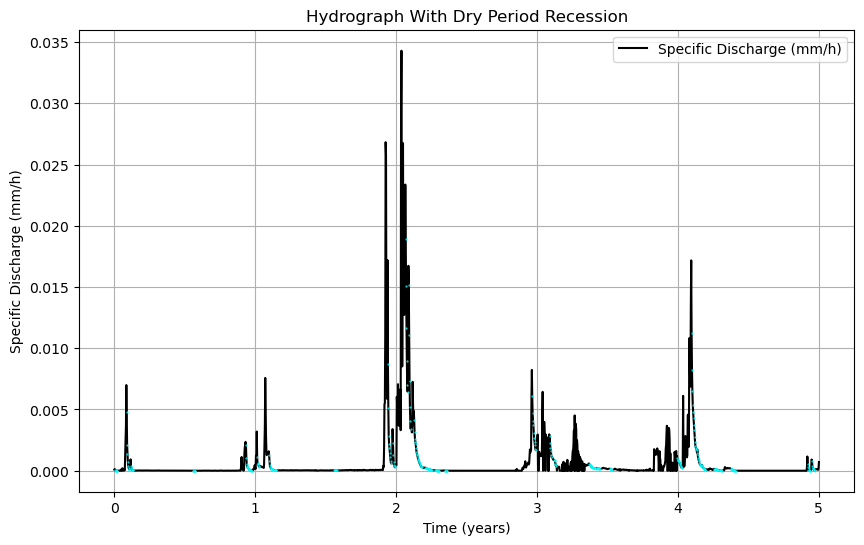

In [23]:
plt.figure(figsize=(10, 6))
# Convert time from hours to years and shift the time axis to start at year 0
time_years = (time_short - time_short[0]) / 8760

# Plot specific discharge
plt.plot(time_years, dis_short, label = "Specific Discharge (mm/h)", color = "black")

# Plot recession periods
for recession in recessions:
    recession_time = (recession[:, 0] - time_short[0]) / 8760  # Convert time to years and shift it to start from 0
    recession_discharge = recession[:, 1]
    plt.plot(recession_time, recession_discharge, 'o', color='cyan', markersize=0.5)

# Add labels and title
plt.title("Hydrograph With Dry Period Recession")
plt.xlabel('Time (years)')
plt.ylabel('Specific Discharge (mm/h)')
plt.grid(True)
plt.legend()
plt.savefig("hydrograph", dpi = 300)